#### Build a model that will predict whether the **average cost to income ratio for cancer** care is above the average ratio or equal to or below the average ratio.

**Important:** From here on out, you will be working with _all_ states, not just Tennessee!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

%matplotlib inline

### First, read in the cancer data, rename the `analysis_value` column, and slice down to the columns we care about.

In [3]:
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
cancer_costs_df = cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'})
cancer_costs_df = cancer_costs_df[['state', 'county', 'urban', 'cancer_avg_cost']]
cancer_costs_df.head(2)

,state,county,urban,cancer_avg_cost
0,ALABAMA,Autauga County,Urban,19293
1,ALABAMA,Baldwin County,Rural,17151


### Import income data, aggregate, and slice down to the columns we care about.

In [7]:
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df = income_df[['STATE', 'COUNTYNAME', 'N02650', 'A02650']]
income_df.columns = ['state', 'county', 'returns_with_total_inc','total_inc_amt']
income_df.head()

,state,county,returns_with_total_inc,total_inc_amt
0,AL,Alabama,19140,-1657452
1,AL,Alabama,285760,1632624
2,AL,Alabama,529780,9158151
3,AL,Alabama,495750,18016190
4,AL,Alabama,263130,16321828


Note that we must `groupby` both `state` **and** county.

In [9]:
income_agg = income_df.groupby(['state','county']).agg('sum').reset_index()
income_agg['avg_income'] = round(income_agg.total_inc_amt * 1000 / income_agg.returns_with_total_inc, 0)
income_agg = income_agg[['state','county', 'avg_income']]
income_agg.head(2)

,state,county,avg_income
0,AK,Alaska,68636.0
1,AK,Aleutians East Borou,48984.0


### Before you can merge county incomes and combined_df, the data is the `state` columns will need to match

In [10]:
state_abbrev = pd.read_csv('../data/state_abbrev.csv')
state_abbrev.head(2)

,name,abbrev
0,ALABAMA,AL
1,ALASKA,AK


In [11]:
cancer_costs_df.head(2)

,state,county,urban,cancer_avg_cost
0,ALABAMA,Autauga County,Urban,19293
1,ALABAMA,Baldwin County,Rural,17151


In [61]:
state_abbrev.set_index('name')['abbrev'].to_dict()

{'ALABAMA': 'AL',
 'ALASKA': 'AK',
 'ARIZONA': 'AZ',
 'ARKANSAS': 'AR',
 'CALIFORNIA': 'CA',
 'COLORADO': 'CO',
 'CONNECTICUT': 'CT',
 'DELAWARE': 'DE',
 'DISTRICT OF COLUMBIA': 'DC',
 'FLORIDA': 'FL',
 'GEORGIA': 'GA',
 'HAWAII': 'HI',
 'IDAHO': 'ID',
 'ILLINOIS': 'IL',
 'INDIANA': 'IN',
 'IOWA': 'IA',
 'KANSAS': 'KS',
 'KENTUCKY': 'KY',
 'LOUISIANA': 'LA',
 'MAINE': 'ME',
 'MARYLAND': 'MD',
 'MASSACHUSETTS': 'MA',
 'MICHIGAN': 'MI',
 'MINNESOTA': 'MN',
 'MISSISSIPPI': 'MS',
 'MISSOURI': 'MO',
 'MONTANA': 'MT',
 'NEBRASKA': 'NE',
 'NEVADA': 'NV',
 'NEW HAMPSHIRE': 'NH',
 'NEW JERSEY': 'NJ',
 'NEW MEXICO': 'NM',
 'NEW YORK': 'NY',
 'NORTH CAROLINA': 'NC',
 'NORTH DAKOTA': 'ND',
 'OHIO': 'OH',
 'OKLAHOMA': 'OK',
 'OREGON': 'OR',
 'PENNSYLVANIA': 'PA',
 'RHODE ISLAND': 'RI',
 'SOUTH CAROLINA': 'SC',
 'SOUTH DAKOTA': 'SD',
 'TENNESSEE': 'TN',
 'TEXAS': 'TX',
 'UTAH': 'UT',
 'VERMONT': 'VT',
 'VIRGINIA': 'VA',
 'WASHINGTON': 'WA',
 'WEST VIRGINIA': 'WV',
 'WISCONSIN': 'WI',
 'WYOMING': 'WY

In [12]:
cancer_costs_df['state'] = cancer_costs_df['state'].map(state_abbrev.set_index('name')['abbrev'].to_dict())
cancer_costs_df.head(2)

,state,county,urban,cancer_avg_cost
0,AL,Autauga County,Urban,19293
1,AL,Baldwin County,Rural,17151


In [13]:
cancer_costs_df = pd.merge(cancer_costs_df, income_agg, on = ['state', 'county'], how = 'inner')
cancer_costs_df.head(2)

,state,county,urban,cancer_avg_cost,avg_income
0,AL,Autauga County,Urban,19293,55843.0
1,AL,Baldwin County,Rural,17151,62832.0


### What is our target variable? What are the predictor variables?
- The target is whether or not `cancer_avg_cost` is above or below the mean.
- Currently, the only predictor we have is urban/rural.

In [64]:
cancer_costs_df['cancer_cost_ratio'] = cancer_costs_df['cancer_avg_cost'] / cancer_costs_df['avg_income']

In [65]:
cancer_costs_df.head()

,state,county,urban,cancer_avg_cost,avg_income,cancer_cost_ratio
0,AL,Autauga County,Urban,19293,55843.0,0.345486
1,AL,Baldwin County,Rural,17151,62832.0,0.272966
2,AL,Barbour County,Rural,19469,40269.0,0.483474
3,AL,Bibb County,Urban,17234,47380.0,0.363740
4,AL,Blount County,Urban,20317,49535.0,0.410154


In [66]:
avg_cancer_ratio = cancer_costs_df.cancer_cost_ratio.mean()
avg_cancer_ratio

0.4149767494462439

In [67]:
cancer_costs_df['above_avg_cancer_ratio'] = cancer_costs_df['cancer_cost_ratio'] > avg_cancer_ratio

In [68]:
cancer_costs_df.head()

,state,county,urban,cancer_avg_cost,avg_income,cancer_cost_ratio,above_avg_cancer_ratio
0,AL,Autauga County,Urban,19293,55843.0,0.345486,False
1,AL,Baldwin County,Rural,17151,62832.0,0.272966,False
2,AL,Barbour County,Rural,19469,40269.0,0.483474,True
3,AL,Bibb County,Urban,17234,47380.0,0.363740,False
4,AL,Blount County,Urban,20317,49535.0,0.410154,False


We need to encode the urban/rural column using `get_dummies`.

In [69]:
cancer_costs_df = pd.get_dummies(cancer_costs_df, columns = ['urban'], drop_first = True)
cancer_costs_df.head(3)

,state,county,cancer_avg_cost,avg_income,cancer_cost_ratio,above_avg_cancer_ratio,urban_Urban
0,AL,Autauga County,19293,55843.0,0.345486,False,1
1,AL,Baldwin County,17151,62832.0,0.272966,False,0
2,AL,Barbour County,19469,40269.0,0.483474,True,0


In [70]:
cancer_costs_df.shape

(3066, 7)

# Using only urban/rural to predict

In [71]:
X = cancer_costs_df[['urban_Urban']]
y = cancer_costs_df.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

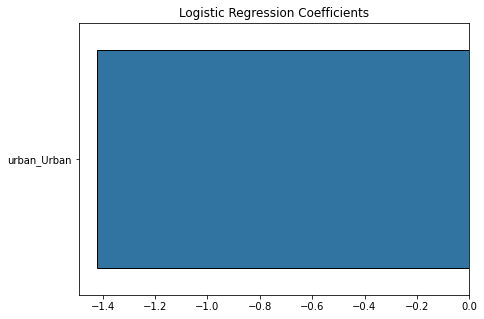

In [72]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients');

Looks like a county being urban decreases the chances that the cost ratio will be above average.

In [73]:
# Model using no predictors
y_test.value_counts(normalize = True)

True     0.500652
False    0.499348
Name: above_avg_cancer_ratio, dtype: float64

In [74]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6544980443285529


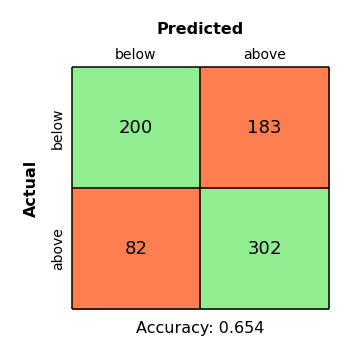

In [75]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [76]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.71      0.52      0.60       383
        True       0.62      0.79      0.70       384

    accuracy                           0.65       767
   macro avg       0.67      0.65      0.65       767
weighted avg       0.67      0.65      0.65       767



#### Let's check AUC

In [77]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.654325772410792


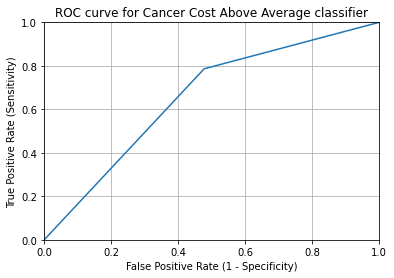

In [78]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Incorporting some of the geographic profile data

In [79]:
geographic_info = pd.read_csv('../data/geographic_profile.csv')

In [80]:
geographic_info

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),...,Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,AL,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,...,0.101183,0.106110,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252
1,AL,Baldwin County,51365.0,86250.0,26010.0,59570.0,68369.0,79153.0,69484.0,67693.0,...,0.124101,0.129932,0.077699,0.069984,0.293833,0.274180,0.032243,0.037965,0.035886,0.062713
2,AL,Barbour County,33956.0,NaN,16450.0,42631.0,42429.0,44563.0,46563.0,48250.0,...,0.093651,0.226190,NaN,0.162366,NaN,0.221912,NaN,0.083538,NaN,0.128247
3,AL,Bibb County,39776.0,111477.0,19127.0,41183.0,43520.0,51760.0,68375.0,76579.0,...,0.110305,0.206096,NaN,0.106445,NaN,0.214445,NaN,0.036667,NaN,0.071429
4,AL,Blount County,46212.0,50723.0,22171.0,50601.0,60406.0,64705.0,54390.0,48913.0,...,0.043669,0.186762,NaN,0.098941,NaN,0.132788,NaN,0.049601,NaN,0.059515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,WY,Sweetwater County,68233.0,94211.0,36884.0,77074.0,74030.0,89070.0,90544.0,103275.0,...,0.136929,0.053565,NaN,0.089024,NaN,0.125851,NaN,0.031863,NaN,0.050685
3216,WY,Teton County,75594.0,NaN,40613.0,86401.0,104185.0,106379.0,102321.0,78681.0,...,0.285209,0.000000,NaN,0.046450,NaN,0.344267,NaN,0.027027,NaN,0.021234
3217,WY,Uinta County,53323.0,78750.0,26641.0,59345.0,56186.0,79000.0,55822.0,125663.0,...,0.054170,0.075666,NaN,0.097962,NaN,0.150205,NaN,0.101167,NaN,0.063908
3218,WY,Washakie County,46212.0,63250.0,25625.0,61114.0,66894.0,61667.0,42500.0,NaN,...,0.153680,0.064935,NaN,0.044981,NaN,0.081868,NaN,0.041262,NaN,0.074419


**Important:** Check for missing values and see what columns are available.

In [81]:
geographic_info.isna().sum()

state                                                                    0
county                                                                   0
Median Household Income (5y Average)                                     0
Median Household Income for +7-person Households (5y Avg.)             777
Median Household Income for 1-person Households (5y Avg.)                0
Median Household Income for 2-person Households (5y Avg.)                1
Median Household Income for 3-person Households (5y Avg.)               19
Median Household Income for 4-person Households (5y Avg.)               39
Median Household Income for 5-person Households (5y Avg.)              125
Median Household Income for 6-person Households (5y Avg.)              455
Percent Below Federal Poverty Level (1y Avg.)                         2389
Percent Below Federal Poverty Level (5y Avg.)                            0
Percent of +4 Person Households with +3 Workers (5y Avg.)                0
Percent of +4 Person Hous

Grabbing the usable predictors. Note that I did not use Median Household Income.

In [82]:
geographic_info = geographic_info[['state', 'county', 'Percent Below Federal Poverty Level (5y Avg.)']]
geographic_info.head(2)

,state,county,Percent Below Federal Poverty Level (5y Avg.)
0,AL,Autauga County,0.122660
1,AL,Baldwin County,0.129938


In [83]:
cancer_costs_df = pd.merge(left = cancer_costs_df, right = geographic_info)

In [84]:
cancer_costs_df.shape

(3065, 8)

In [85]:
cancer_costs_df.head()

,state,county,cancer_avg_cost,avg_income,cancer_cost_ratio,above_avg_cancer_ratio,urban_Urban,Percent Below Federal Poverty Level (5y Avg.)
0,AL,Autauga County,19293,55843.0,0.345486,False,1,0.122660
1,AL,Baldwin County,17151,62832.0,0.272966,False,0,0.129938
2,AL,Barbour County,19469,40269.0,0.483474,True,0,0.263737
3,AL,Bibb County,17234,47380.0,0.363740,False,1,0.164539
4,AL,Blount County,20317,49535.0,0.410154,False,1,0.165344


In [86]:
cancer_costs_df.columns

Index(['state', 'county', 'cancer_avg_cost', 'avg_income', 'cancer_cost_ratio',
       'above_avg_cancer_ratio', 'urban_Urban',
       'Percent Below Federal Poverty Level (5y Avg.)'],
      dtype='object')

In [87]:
X = cancer_costs_df[['urban_Urban', 'Percent Below Federal Poverty Level (5y Avg.)']]
y = cancer_costs_df.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

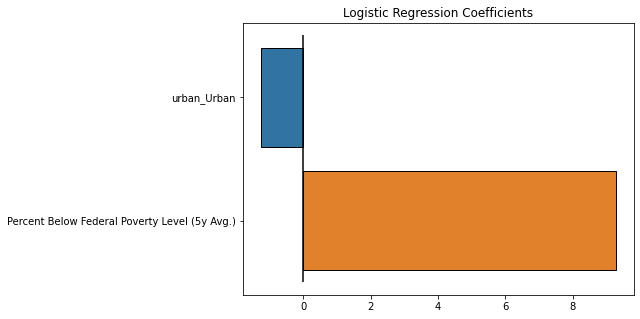

In [88]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')
ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

In [89]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7405475880052151


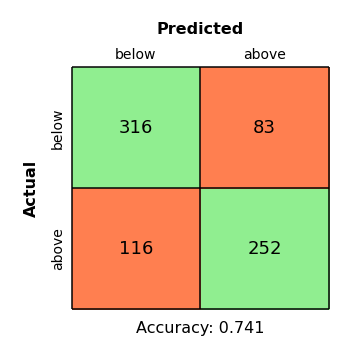

In [90]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [91]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8011536994660565


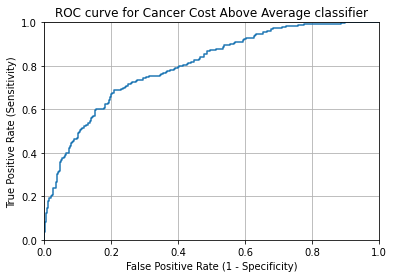

In [92]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)